In [1]:
import sys
sys.path.append(r"C:\Users\TCSPC\Documents\__Arunachalam\pyTCSPC")

In [2]:
import pyTCSPC as pc

In [3]:
%cd C:\Users\TCSPC\Documents\__Arunachalam\29 - FCS setup\fov1

C:\Users\TCSPC\Documents\__Arunachalam\29 - FCS setup\fov1


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# 1 micron = 4.65 px
fov_dim_1xzoom = 440 # um
zoom = 8 # for the test image
npx = 256 # for the test image
pxsize = fov_dim_1xzoom / (zoom*npx)
pxsize # in um

0.21484375

In [6]:
# 1 micron = 4.65 px
1/pxsize

4.654545454545454

(2, 256, 256, 256)
(2, 256, 256, 256)


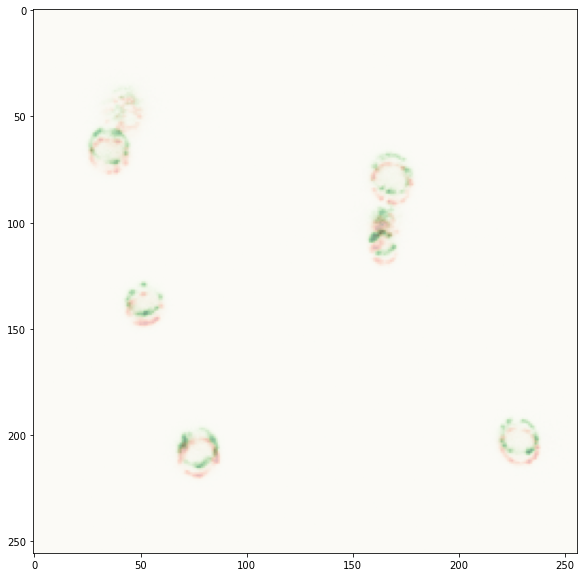

In [34]:
# this more or less checks out

plt.figure(figsize=(10,10))
im = pc.SDT("SDT_X-1.sdt").intensity_image()[0]
plt.imshow(np.roll(im, 0, axis=0), alpha=0.5, cmap="Reds")
# plt.imshow(np.roll(im, -5, axis=0), alpha=0.5, cmap="Reds")
im = pc.SDT("SDT.sdt").intensity_image()[0]
plt.imshow(im, alpha=0.5, cmap="Greens")
# im = pc.SDT("SDT_X+1.sdt").intensity_image()[0]
# # plt.imshow(np.roll(im, 5, axis=0), alpha=0.5, cmap="Reds")
# plt.imshow(np.roll(im, 5, axis=0), alpha=0.5, cmap="Blues")

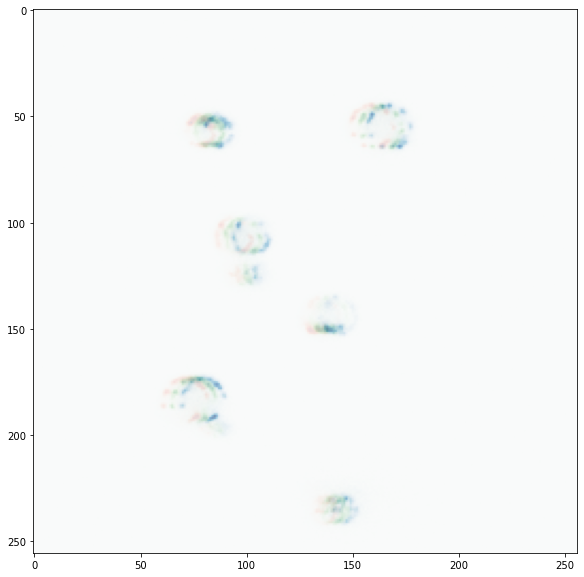

In [65]:
# this more or less checks out

plt.figure(figsize=(10,10))
im = pc.SDT("move_Y/SDT_Y-1.sdt").intensity_image(block=0)
plt.imshow(np.roll(im, 0, axis=0), alpha=0.5, cmap="Reds")
# plt.imshow(np.roll(im, -5, axis=0), alpha=0.5, cmap="Reds")
im = pc.SDT("move_Y/SDT.sdt").intensity_image(block=0)
plt.imshow(im, alpha=0.5, cmap="Greens")
im = pc.SDT("move_Y/SDT_Y+1.sdt").intensity_image(block=0)
# # plt.imshow(np.roll(im, 5, axis=0), alpha=0.5, cmap="Reds")
plt.imshow(np.roll(im, 0, axis=0), alpha=0.5, cmap="Blues")

In [61]:
# we can see that moving the stage in the x-direction moves the image vertically
# (and so moving the stage in the y-direction moves the image horizontally)

# also...
# moving the stage -1 um in the x direction moves the image "down" (i.e. larger-number vertical coordinate)
# moving the stage -1 um in the y direction moves the image "left" (i.e. smaller-number horizontal coordinate)

In [62]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_otsu

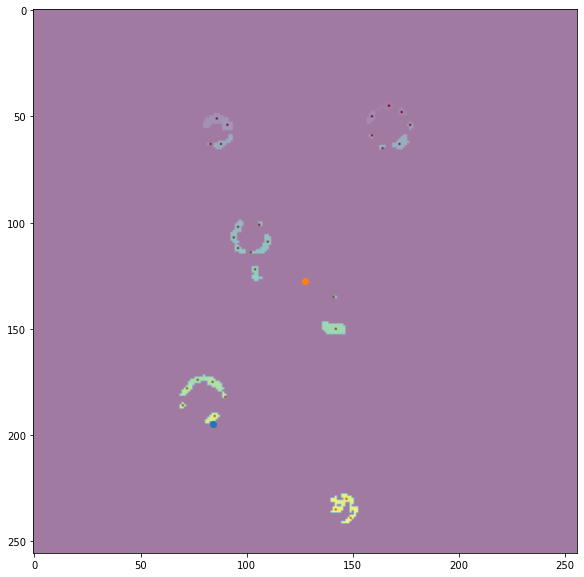

In [70]:
im_binary = im > threshold_otsu(im)

distance = ndi.distance_transform_edt(im_binary)
coords = peak_local_max(distance, footprint=np.ones((5, 5)), min_distance=5)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=im_binary)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(labels)
ax.imshow(0.99*(markers > 0), cmap="Reds", alpha=0.5)
plt.scatter(84, 195)
plt.scatter(127.5, 127.5)

In [71]:
def calc_displacement(origin, destination=[127.5,127.5], px_to_micron=fov_dim_1xzoom / (zoom*npx)):
    dxy = destination - origin
    dX = -1*dxy[0]*px_to_micron
    dY = dxy[1]*px_to_micron
    return dX, dY

curr_index, coords[curr_index], calc_displacement(coords[curr_index])

(1, array([51, 86], dtype=int64), (-16.435546875, 8.916015625))

In [76]:
acquisition_length_s, buffer_length_s = 3.0, 0.1

In [75]:
y, x = tuple(coords.T)
n = len(x)
xa = np.tile(x, (n,1))
dx2 = np.square(xa - xa.T)
ya = np.tile(y, (n,1))
dy2 = np.square(ya - ya.T)
dR = np.sqrt(dx2 + dy2)
ind_maxdist_0, ind_maxdist_1 = np.unravel_index(np.argmax(dR, axis=None), dR.shape)
dR[np.arange(n), np.arange(n)] = np.inf


already_measured = np.zeros_like(x, dtype=bool)

curr_index = ind_maxdist_0
print(curr_index)

# acquire current point
dX, dY = calc_displacement(coords[curr_index])
X_set_pos_rel(dX)
X_set_pos_rel(dY)
mmc.setShutterOpen(True)
time.sleep(acquisition_length_s+buffer_length_s)
mmc.setShutterOpen(False)

already_measured[curr_index] = True
dR[:,curr_index] = np.inf


while np.any(~already_measured):
    index_closest = np.argmin(dR[curr_index])
    curr_index = index_closest
    print(curr_index)
    
    # acquire current point
    dX, dY = calc_displacement(coords[curr_index])
    X_set_pos_rel(dX)
    X_set_pos_rel(dY)
    mmc.setShutterOpen(True)
    time.sleep(acquisition_length_s+buffer_length_s)
    mmc.setShutterOpen(False)
    
    already_measured[curr_index] = True
    dR[:,curr_index] = np.inf

1
4
14
25
12
6
20
27
13
5
24
28
0
22
3
11
17
18
8
10
9
19
26
23
16
7
15
21
2
